# Newton method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax
import time

# We enable double precision in JAX
jax.config.update("jax_enable_x64", True)

We consider a random matrix $A \in \mathbb{R}^{n\times n}$, with $n = 100$ and a random vector $\mathbf{x}_{\text{ex}} \in \mathbb{R}^n$.
We define then $\mathbf{b} = A \, \mathbf{x}_{\text{ex}}$.


In [2]:
n = 100

np.random.seed(0)
A = np.random.randn(n, n)
x_ex = np.random.randn(n)
b = A @ x_ex

Define the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_2^2
$$


In [3]:
def loss(x):
    return jnp.sum(jnp.square(A @ x - b))


print(loss(x_ex))

0.0


By using the `jax` library, implement and compile functins returning the gradient ($\nabla \mathcal{J}(\mathbf{x})$) and the hessian ($\nabla^2 \mathcal{J}(\mathbf{x})$) of the loss function.


In [4]:
grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

Check that the results are correct (up to machine precision).


In [5]:
np.random.seed(0)
x_guess = np.random.randn(n)

G_ad = grad_jit(x_guess)
G_ex = 2 * A.T @ (A @ x_guess - b)
print(np.linalg.norm(G_ad - G_ex))

H_ad = hess_jit(x_guess)
H_ex = 2 * A.T @ A
print(np.linalg.norm(H_ad - H_ex))

1.9061180593670305e-12
0.0


Exploit the formula

$$
\nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v} = \nabla_{\mathbf{x}} \phi(\mathbf{x}, \mathbf{v})
$$

where

$$
\phi(\mathbf{x}, \mathbf{v}) := \nabla \mathcal{J}(\mathbf{x}) \cdot \mathbf{v}
$$

to write an optimized function returning the hessian-vector-product

$$
(\mathbf{x}, \mathbf{v}) \mapsto \nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v}.
$$

Compare the computational performance w.r.t. the full hessian computation.


In [6]:
np.random.seed(1)
v = np.random.randn(n)

hvp_basic = lambda x, v: hess(x) @ v
gvp = lambda x, v: jnp.dot(grad(x), v)
hvp = lambda x, v: jax.grad(gvp, argnums=0)(x, v)

hvp_basic_jit = jax.jit(hvp_basic)
hvp_jit = jax.jit(hvp)

Hv_ad = hvp_jit(x_guess, v)
Hv_ex = H_ex @ v
print(np.linalg.norm(Hv_ad - Hv_ex))

1.5923499043932032e-12


In [7]:
%timeit hvp_basic_jit(x_guess, v)
%timeit hvp_jit(x_guess, v)

122 μs ± 4.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
18.7 μs ± 353 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Implement the Newton method for the minimization of the loss function $\mathcal{L}$. Set a maximim number of 100 iterations and a tolerance on the increment norm of $\epsilon = 10^{-8}$.


In [8]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

elapsed_time = 0

for epoch in range(num_epochs):
    t0 = time.time()
    H = hess_jit(x)
    G = grad_jit(x)
    incr = np.linalg.solve(H, -G)
    elapsed_time += time.time() - t0
    x += incr

    print("============ epoch %d" % epoch)
    print("loss: %1.3e" % loss_jit(x))
    print("grad: %1.3e" % np.linalg.norm(G))
    print("incr: %1.3e" % np.linalg.norm(incr))

    if np.linalg.norm(incr) < eps:
        break

print(f"Elapsed time: {elapsed_time:.4f} [s]")
rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

============ epoch 0
loss: 8.858e-23
grad: 6.026e+03
incr: 1.548e+01
============ epoch 1
loss: 1.198e-27
grad: 2.970e-12
incr: 9.546e-10
Elapsed time: 0.0657 [s]
Relative error: 3.506e-14


In [9]:
def conjugate_gradient(matvec_fn, b, tol=1e-12, max_iter=1000):
    """
    Conjugate Gradient Solver for Ax = b, where A is only accessible via matvec_fn.
    """
    x = jnp.zeros_like(b)
    r = b - matvec_fn(x)  # Residual
    p = r
    rsold = jnp.dot(r, r)

    for _ in range(max_iter):
        Ap = matvec_fn(p)
        alpha = rsold / jnp.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = jnp.dot(r, r)
        if jnp.sqrt(rsnew) < tol:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    return x


x = x_guess.copy()
num_epochs = 100
eps = 1e-8

elapsed_time = 0

for epoch in range(num_epochs):
    t0 = time.time()
    G = grad_jit(x)
    incr = conjugate_gradient(lambda y: hvp_jit(x, y), -G)
    elapsed_time += time.time() - t0
    x += incr

    print("============ epoch %d" % epoch)
    print("loss: %1.3e" % loss_jit(x))
    print("grad: %1.3e" % np.linalg.norm(G))
    print("incr: %1.3e" % np.linalg.norm(incr))

    if np.linalg.norm(incr) < eps:
        break

print(f"Elapsed time: {elapsed_time:.4f} [s]")
rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

============ epoch 0
loss: 6.850e-24
grad: 6.026e+03
incr: 1.548e+01
============ epoch 1
loss: 6.644e-24
grad: 4.355e-12
incr: 3.349e-13
Elapsed time: 0.2462 [s]
Relative error: 2.716e-11


Repeat the optimization loop for the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_4^4
$$


In [10]:
def loss(x):
    return jnp.sum((A @ x - b) ** 4)


grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

convergence reached!
epochs: 50
relative error: 1.657e-09


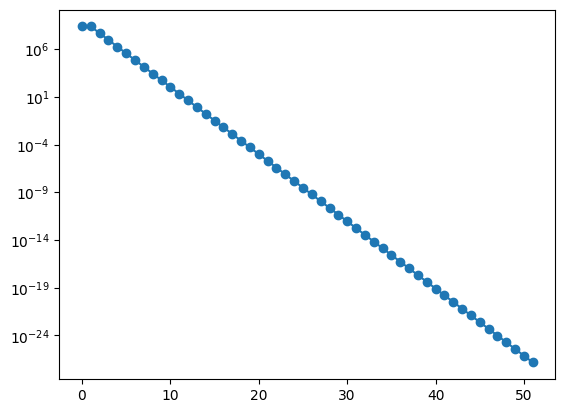

In [11]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

hist = [loss_jit(x)]
t0 = time.time()
for epoch in range(num_epochs):
    l = loss_jit(x)
    hist.append(l)
    H = hess_jit(x)
    G = grad_jit(x)
    incr = np.linalg.solve(H, -G)
    x += incr
    if np.linalg.norm(incr) < eps:
        print("convergence reached!")
        break
ttot = time.time() - t0

plt.semilogy(hist, "o-")
print("epochs: %d" % epoch)
print("relative error: %1.3e" % (np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)))

# Quasi-Newton Optimization with BFGS Update

This algorithm minimizes an objective function $ f(\mathbf{x}) $ using a quasi-Newton method with the BFGS update. The goal is to iteratively update the solution $ \mathbf{x} $ and approximate the inverse Hessian until convergence criteria are met.

## Algorithm

1. **Initialization**:

   - Set the initial guess $ \mathbf{x} = \mathbf{x}\_{\text{guess}} $.
   - Let $ \mathbf{I} $ be the identity matrix, and initialize $ B^{-1} = \mathbf{I} $.
   - Compute the initial gradient $ \nabla f = \nabla f(\mathbf{x}\_{\text{guess}}) $.
   - Initialize the loss history: $ \text{history} = [f(\mathbf{x}_{\text{guess}})] $.
   - Set $ \text{epoch} = 0 $.

   $$
   B^{-1} = \mathbf{I}, \quad \nabla f = \nabla f(\mathbf{x}_{\text{guess}}), \quad \text{history} = [f(\mathbf{x}_{\text{guess}})]
   $$

2. **Iterative Updates**:

   - While $ \|\nabla f\| > \text{tol} $ and epoch $<$ max epoch:

     - Increment the epoch counter:

       $$
       \text{epoch} \leftarrow \text{epoch} + 1
       $$

     - Compute the search direction:

       $$
       \mathbf{p} = -B^{-1} \nabla f
       $$

     - Perform a line search to find the step size $ \alpha $ using `sp.optimize.line_search`:

       $$
       \alpha \leftarrow \text{line\_search}(f, \nabla f, \mathbf{x}, \mathbf{p})
       $$

       If $ \alpha $ is not found, set $ \alpha = 10^{-8} $.

     - Update the solution vector:

       $$
       \mathbf{x}_{\text{new}} = \mathbf{x} + \alpha \mathbf{p}
       $$

     - Compute the displacement:

       $$
       \mathbf{s} = \mathbf{x}_{\text{new}} - \mathbf{x}
       $$

     - Update $ \mathbf{x} $:

       $$
       \mathbf{x} \leftarrow \mathbf{x}_{\text{new}}
       $$

     - Compute the new gradient and gradient difference:

       $$
       \nabla f_{\text{new}} = \nabla f(\mathbf{x}), \quad \mathbf{y} = \nabla f_{\text{new}} - \nabla f
       $$

       Update $ \nabla f $:

       $$
       \nabla f \leftarrow \nabla f_{\text{new}}
       $$

     - Compute the scalar $ \rho $:

       $$
       \rho = \frac{1}{\mathbf{y}^\top \mathbf{s}}
       $$

     - Update the inverse Hessian approximation $ B^{-1} $ using the Sherman–Morrison formula:

       $$
       \mathbf{E} = \mathbf{I} - \rho \mathbf{y} \mathbf{s}^\top
       $$

       $$
       B^{-1} \leftarrow \mathbf{E}^\top B^{-1} \mathbf{E} + \rho \mathbf{s} \mathbf{s}^\top
       $$

     - Append the current loss value to history:
       $$
       \text{history.append}(f(\mathbf{x}))
       $$


/var/folders/4d/xybtwjyj2d3dv4p2_6s1yccw0000gn/T/ipykernel_26222/910583572.py:21: LineSearchWarning: The line search algorithm did not converge
  line_search = sp.optimize.line_search(loss_jit, grad_jit, x, p)


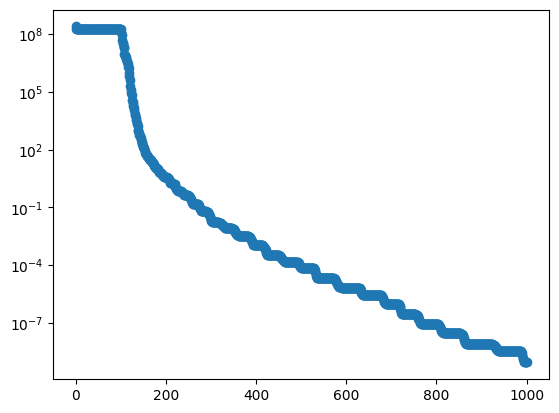

In [12]:
max_epochs = 1000
tol = 1e-8

import scipy as sp

np.random.seed(0)

epoch = 0
x = x_guess.copy()
I = np.eye(x.size)
Binv = I
grad = grad_jit(x_guess)
history = [loss_jit(x_guess)]

while np.linalg.norm(grad) > tol and epoch < max_epochs:
    epoch += 1
    # search direction
    p = -Binv @ grad

    # line search
    line_search = sp.optimize.line_search(loss_jit, grad_jit, x, p)
    alpha = line_search[0]
    alpha = 1e-8 if alpha is None else alpha
    x_new = x + alpha * p

    # computing y and s
    s = x_new - x
    x = x_new
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    grad = grad_new

    # Sherman–Morrison update
    rho = 1.0 / (np.dot(y, s))
    E = I - rho * np.outer(y, s)
    Binv = E.T @ Binv @ E + rho * np.outer(s, s)

    history.append(loss_jit(x))

plt.semilogy(history, "o-")